In [10]:
import torch

# Check number of GPUs
num_gpus = torch.cuda.device_count()
print("Number of GPU(s):", num_gpus)

# Check GPU name
if num_gpus > 0:
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU found.")

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU(s): 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Using device: cuda


In [11]:
import pandas as pd

df = pd.read_csv('combined_dfv2.csv', dtype=str)

# remove NA from text and label columns
df = df.dropna(subset=['max_predicted_aspect', 'Combined Text'])

# filter sample 
filtered_df = df[df['Month of Response Date'] == 'Apr-24']

# rename category 'Quality'
filtered_df['max_predicted_aspect'] = filtered_df['max_predicted_aspect'].replace({'Product/print quality': 'Quality'})

filtered_df.head(3)

C:\Users\royle\AppData\Local\Temp\ipykernel_19508\2115066700.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['max_predicted_aspect'] = filtered_df['max_predicted_aspect'].replace({'Product/print quality': 'Quality'})


,Survey ID,Product Name,Print Customer Region,LTR,Source Type,Survey language,Review Source,Star Rating,Product Family,Supplies Family,...,Model Name,Combined Text,Ink Supply Type,token_count,Month of Response Date,predicted_level1,predicted_probabilities,max_predicted_probability,max_predicted_level1,max_predicted_aspect
18,110020182,HP 63 Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,HP 63 Black Original Ink Cartridge,"Excllent quality; easy to order, received prom...",IPH,7,Apr-24,"Logistic Handling, General satisfied","['0.8352197918762199', '0.7786848755893012']",0.880666667,Brand Loyalty,Others
108,123460320,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,HP 65XL Black Original Ink Cartridge,Great price and arrived even earlier than stated.,IPH,8,Apr-24,Logistic Handling,['0.7908739113381595'],0.796588235,Brand Loyalty,Others
137,132417974,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,HP 65XL Black Original Ink Cartridge,Ink gets used up way to quickly for the price ...,IPH,40,Apr-24,Others,['0'],0.903254902,Brand Loyalty,Others


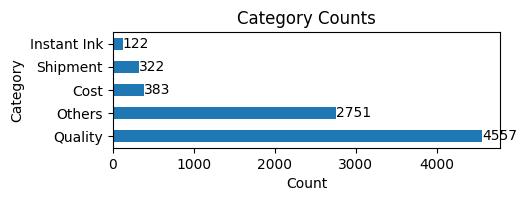

In [12]:
import matplotlib.pyplot as plt

value_counts = filtered_df['max_predicted_aspect'].value_counts()

# horizontal bar chart plot
plt.figure(figsize=(5, 1.5))
ax = value_counts.plot(kind='barh')
for i in ax.containers:
    ax.bar_label(i)

plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Category Counts')
plt.show()

C:\Users\royle\AppData\Local\Temp\ipykernel_19508\4090088333.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = filtered_df.groupby('max_predicted_aspect').apply(lambda x: x.sample(n=n_sample, random_state=93)).reset_index(drop=True)


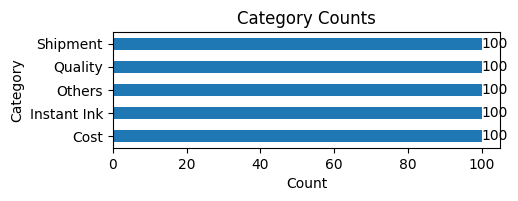

In [13]:
# sample equal no. of records from each label
n_sample = 100
sampled_df = filtered_df.groupby('max_predicted_aspect').apply(lambda x: x.sample(n=n_sample, random_state=93)).reset_index(drop=True)

value_counts = sampled_df['max_predicted_aspect'].value_counts()

# horizontal bar chart plot
plt.figure(figsize=(5, 1.5))
ax = value_counts.plot(kind='barh')
for i in ax.containers:
    ax.bar_label(i)

plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Category Counts')
plt.show()

In [14]:
# text input : Combined Text
# label ouput : max_predicted_aspect

data_texts = sampled_df['Combined Text'].to_list() # text 

from sklearn.preprocessing import LabelEncoder
# Convert labels to numeric categories
label_encoder = LabelEncoder()

data_labels = sampled_df['max_predicted_aspect'].to_list()  # Original labels
data_labels = label_encoder.fit_transform(data_labels)  # Numeric labels

# Get the mapping of original labels to numeric labels
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Print the mapping
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'Cost': 0, 'Instant Ink': 1, 'Others': 2, 'Quality': 3, 'Shipment': 4}


In [67]:
import torch
import numpy as np 
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=42)

# Create a PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# Load model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Define compute_metrics function to calculate accuracy, precision, recall, and f1
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Set device
if torch.cuda.is_available():
    model.cuda()

# Define training arguments
training_args = TrainingArguments(
    # output_dir='./results', -- directory where model checkpoints, configuration files, tokenizer files, and training logs will be saved during and after the training process
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,
    gradient_accumulation_steps=4
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


# Save the model, tokenizer, and training arguments to the output directory
model.save_pretrained('./distilbert aspect classification test')
tokenizer.save_pretrained('./distilbert aspect classification test')


C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\train

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6066876649856567, 'eval_accuracy': 0.16, 'eval_precision': 0.07225442834138486, 'eval_recall': 0.16, 'eval_f1': 0.09845528455284552, 'eval_runtime': 0.2292, 'eval_samples_per_second': 436.371, 'eval_steps_per_second': 30.546, 'epoch': 0.96}
{'loss': 1.6132, 'grad_norm': 1.046966791152954, 'learning_rate': 1.0000000000000002e-06, 'epoch': 1.6}


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.606512427330017, 'eval_accuracy': 0.19, 'eval_precision': 0.08613636363636364, 'eval_recall': 0.19, 'eval_f1': 0.11377777777777778, 'eval_runtime': 0.233, 'eval_samples_per_second': 429.249, 'eval_steps_per_second': 30.047, 'epoch': 1.92}


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6063498258590698, 'eval_accuracy': 0.2, 'eval_precision': 0.09470588235294118, 'eval_recall': 0.2, 'eval_f1': 0.11564227642276423, 'eval_runtime': 0.235, 'eval_samples_per_second': 425.532, 'eval_steps_per_second': 29.787, 'epoch': 2.88}
{'loss': 1.6106, 'grad_norm': 0.8897553086280823, 'learning_rate': 2.0000000000000003e-06, 'epoch': 3.2}


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6056735515594482, 'eval_accuracy': 0.19, 'eval_precision': 0.09560629122272957, 'eval_recall': 0.19, 'eval_f1': 0.10989341692789967, 'eval_runtime': 0.2383, 'eval_samples_per_second': 419.695, 'eval_steps_per_second': 29.379, 'epoch': 4.0}
{'loss': 1.6122, 'grad_norm': 0.6948153376579285, 'learning_rate': 3e-06, 'epoch': 4.8}


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.6054612398147583, 'eval_accuracy': 0.19, 'eval_precision': 0.11459915611814346, 'eval_recall': 0.19, 'eval_f1': 0.11612903225806452, 'eval_runtime': 0.228, 'eval_samples_per_second': 438.598, 'eval_steps_per_second': 30.702, 'epoch': 4.8}
{'train_runtime': 34.8252, 'train_samples_per_second': 57.43, 'train_steps_per_second': 0.861, 'train_loss': 1.6120087305704753, 'epoch': 4.8}


('./distilbert aspect classification test\\tokenizer_config.json',
 './distilbert aspect classification test\\special_tokens_map.json',
 './distilbert aspect classification test\\vocab.txt',
 './distilbert aspect classification test\\added_tokens.json')

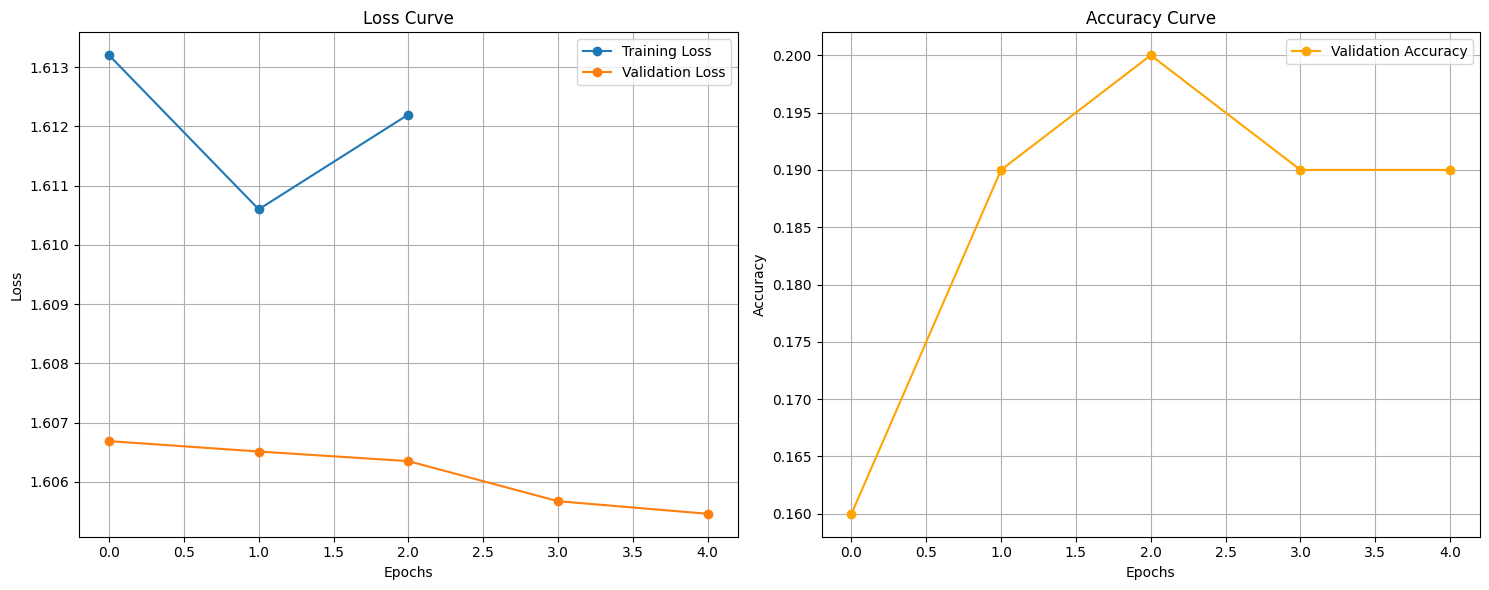

In [72]:
# Plotting loss and accuracy side by side
def plot_training_curves(trainer):
    # Access the logs
    logs = trainer.state.log_history

    # Create lists to hold the loss and accuracy values
    train_loss = []
    eval_loss = []
    eval_accuracy = []

    # Iterate through the logs and collect loss and accuracy values
    for log in logs:
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            eval_loss.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            eval_accuracy.append(log['eval_accuracy'])

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Change to 1 row and 2 columns

    # Plot loss
    axs[0].plot(train_loss, label='Training Loss', marker='o')
    axs[0].plot(eval_loss, label='Validation Loss', marker='o')
    axs[0].set_title('Loss Curve')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot accuracy
    axs[1].plot(eval_accuracy, label='Validation Accuracy', color='orange', marker='o')
    axs[1].set_title('Accuracy Curve')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot training curves
plot_training_curves(trainer)

In [28]:
model_1 = './distilbert aspect classification' # all data 
model_2 = './distilbert aspect classification test' # 100 data points from each label category

model_n = model_1

test_sentences = [
    "I am happy with the delivery.",
    "Great ink quality",
    "Excellent customer service!",
    "Expensive but good",
    "The packaging was damaged.",
    "Worth the money"
]

# Prepare a list to hold predicted categories
predicted_categories = []

# Process each test sentence
for test_sentence in test_sentences:
    # Tokenize the input sentence
    inputs = tokenizer(test_sentence, return_tensors="pt", truncation=True, padding=True)

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Model inference (prediction)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get predicted label
    pred_label = torch.argmax(logits, dim=1).item()

    # Convert predicted label back to category
    predicted_category = label_encoder.inverse_transform([pred_label])[0]
    
    # Append the predicted category to the list
    predicted_categories.append(predicted_category)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Test Sentence': test_sentences,
    'Predicted Category': predicted_categories
})

# Print the label mapping and the results DataFrame
print("Label Mapping:")
print(label_mapping)

print("\nResults DataFrame:")
print(results_df)




Label Mapping:
{'Cost': 0, 'Instant Ink': 1, 'Others': 2, 'Quality': 3, 'Shipment': 4}

Results DataFrame:
                   Test Sentence Predicted Category
0  I am happy with the delivery.           Shipment
1              Great ink quality            Quality
2    Excellent customer service!             Others
3             Expensive but good               Cost
4     The packaging was damaged.             Others
5                Worth the money             Others
